## Installs

In [1]:
# https://github.com/NeuroDiffGym/neurodiffeq

!pip install -U neurodiffeq  # '-U' means update to latest version

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Mount Google Drive (if necessary)

In [2]:
# Mount Googe Drive
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("drive/My Drive/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [3]:
from itertools import chain
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neurodiffeq import diff
from neurodiffeq.solvers import Solver1D, BundleSolver1D
from neurodiffeq.conditions import IVP, DirichletBVP2D
from neurodiffeq.networks import FCNN, Resnet, SinActv, Swish
from neurodiffeq import diff      # the differentiation operation
from neurodiffeq.ode import solve # the ANN-based solver
from neurodiffeq.conditions import IVP   # the initial condition
from neurodiffeq.ode import solve_system
from neurodiffeq.monitors import Monitor1D
from neurodiffeq.generators import Generator1D

import torch
import torch.nn as nn
import torch.nn.functional as F


from torch.nn import MSELoss
from torch.nn import L1Loss
from torch.nn import KLDivLoss
from torch.optim import AdamW

In [4]:
# Check for GPU
torch.cuda.get_device_name(0)

'A100-SXM4-40GB'

## ODE Solver

/usr/local/lib/python3.7/dist-packages/neurodiffeq/monitors.py:48: UserWarning: You seem to be using jupyter notebook with '%matplotlib inline' which can lead to monitor plots not updating. Consider using '%matplotlib notebook' or '%matplotlib widget' instead.
  UserWarning)


Training Progress:   0%|          | 0/750 [00:00<?, ?it/s]

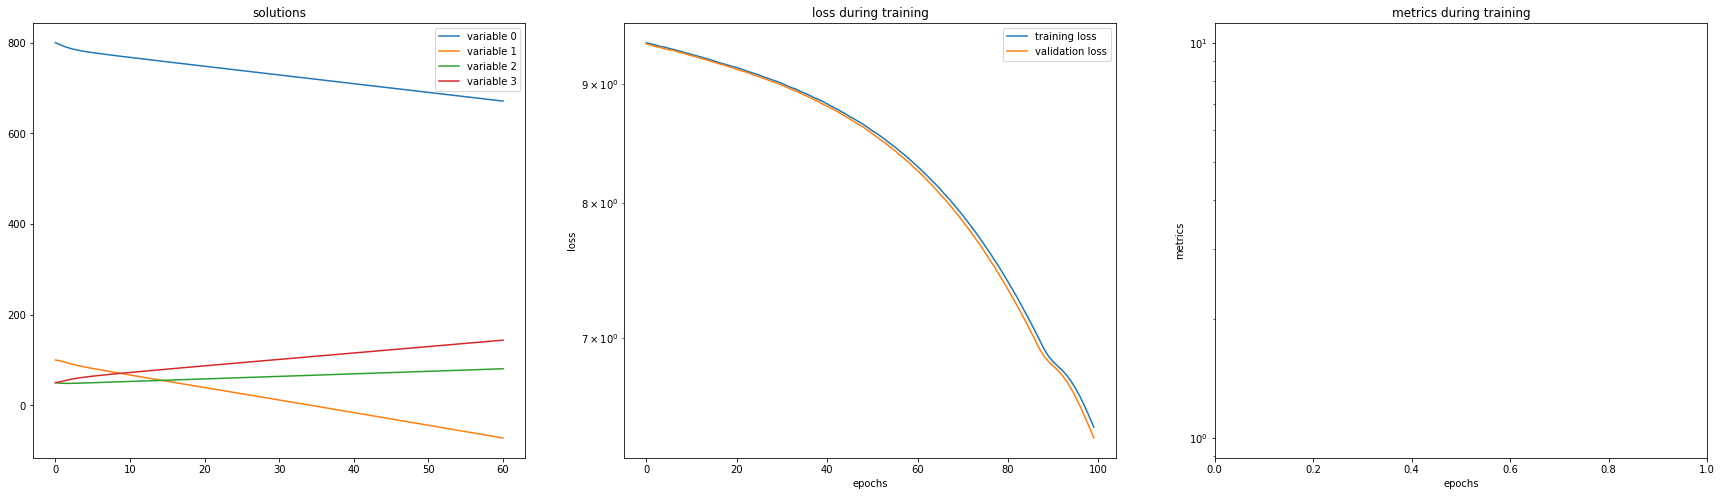

In [5]:
# Specify the ODE system and its parameters
N, beta, mu, sigma, gamma = 1000.0, 0.1, 0.1, 0.09, 0.12 

SEIR = lambda s, e, i, r, t : [ 
    diff(s, t) + ((beta * (e + i) * s) / N), 
    diff(e, t) - (((beta * (e + i) * s) / N) - sigma * e), 
    diff(i, t) - (mu * sigma * e - (gamma * i)), 
    diff(r, t) - (gamma * i),  ]


# Specify the initial conditions
init_vals_SEIR = [
    IVP(t_0=0.0, u_0=800.0),  # S
    IVP(t_0=0.0, u_0=100.0),  # E
    IVP(t_0=0.0, u_0=50.0),   # I
    IVP(t_0=0.0, u_0=50.0),   # R
]

train_gen = Generator1D(size=1000000,  t_min=0.0, t_max=60.0, method='uniform')
valid_gen = Generator1D(size=200000, t_min=0.0, t_max=60.0, method='uniform')

# Specify the network to be used to approximate each dependent variable
nets_SEIR = [
    Resnet(n_input_units=1, n_output_units=1,hidden_units=(16, 16, 16, 16), actv=nn.ELU),
    Resnet(n_input_units=1, n_output_units=1,hidden_units=(16, 16, 16, 16), actv=nn.Mish),
    Resnet(n_input_units=1, n_output_units=1,hidden_units=(16, 16, 16, 16), actv=nn.Tanh),
    Resnet(n_input_units=1, n_output_units=1,hidden_units=(16, 16, 16, 16), actv=nn.ELU)
]


# Create a monitor first
monitor = Monitor1D(t_min=0.0, t_max=60.0, check_every=100)

# Turn the monitor into a Callback instance
monitor_callback = monitor.to_callback()


# Specify the optimizer

opt = AdamW(
    chain.from_iterable(n.parameters() for n in nets_SEIR)                                
)


# Instantiate a solver instance
solver = BundleSolver1D(
    ode_system=SEIR,
    conditions=init_vals_SEIR,
    t_min=0.0,
    t_max=60.0,
    nets=nets_SEIR,
    optimizer=opt,
    criterion=L1Loss(),
    train_generator=train_gen, 
    valid_generator=valid_gen,
)

# Fit the solver (i.e., train the neural networks)
solver.fit(max_epochs=750, callbacks=[monitor_callback])

# Start timer and get the solution 
solution_SEIR = solver.get_solution()

## Plot Data

             S           E          I           R
0   800.000000  100.000000  50.000000   50.000000
1   788.068048   99.517281  45.297712   55.826553
2   776.816213   97.725797  41.201560   61.113626
3   765.991249   96.450220  39.301047   66.017984
4   755.536012   95.695045  38.883340   70.804076
5   745.287575   95.162138  38.875187   75.556552
6   735.182731   94.700080  38.978837   80.317486
7   725.266401   94.239763  39.118992   85.100695
8   715.516543   93.751228  39.272117   89.906099
9   705.912849   93.223808  39.430086   94.727930
10  696.446893   92.656444  39.589958   99.560503
11  687.155200   92.052612  39.750633  104.414959
12  678.031814   91.417562  39.911681  109.292707
13  669.059180   90.756849  40.072925  114.189054
14  660.224462   90.075607  40.234286  119.104425
15  651.554594   89.378254  40.395724  124.044121
16  643.040199   88.668422  40.557218  129.003843
17  634.677079   87.949019  40.718754  133.978984
18  626.453614   87.222320  40.880325  138.971097


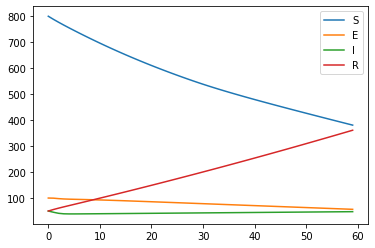

In [6]:
# Convert output into DataFrame
ts = np.linspace(0, 60, 60)
S, E, I, R = solution_SEIR(ts, to_numpy=True)
output = pd.DataFrame({'S': S, 'E': list(E), 'I': list(I), 'R': list(R)}, columns=['S', 'E', 'I', 'R'])

# Plot output
print(output)
output.plot()

## Export Data

In [7]:
# Export csv
output.to_csv("sim-10-p.csv")